# ETL Project
## Members:
* Francisco Estevez
* Alvin Kim
### Data Sources
We extracted data from the Machine Learning Course offered by Google
https://developers.google.com/machine-learning/crash-course/
The dataset we selected is part of the Data preparation of the course
#### Collecting Data > The Size and Quality of a Data Set
The data source contains 20 Millions of records:
    * Movies from 1891 to 2015
    * Rates
    * Genome Scores
#### Final database
Our information is stored in Mongo DB:
    * Movie Rates
    * Movie Genome Scores

### Notebook 4: Extract Gemome Scores, Score Tags, Merge the files with Movies and output to MongoDB

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from pymongo import MongoClient

In [18]:
# The default port used by MongoDB is 27017
# https://docs.mongodb.com/manual/reference/default-mongodb-port/
conn = 'mongodb://localhost:27017'
client = MongoClient(conn)

### Store CSV into DataFrame

In [2]:
csv_file = "Resources/genome-scores.csv"
genome_df = pd.read_csv(csv_file)
genome_df.head()

,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


In [3]:
genome_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11709768 entries, 0 to 11709767
Data columns (total 3 columns):
movieId      int64
tagId        int64
relevance    float64
dtypes: float64(1), int64(2)
memory usage: 268.0 MB


#### The source file includes 11 MILLION of records with Relevance rates for movies

In [4]:
genome_df.describe()

,movieId,tagId,relevance
count,1.170977e+07,1.170977e+07,1.170977e+07
mean,2.584297e+04,5.645000e+02,1.164833e-01
std,3.467615e+04,3.256254e+02,1.542463e-01
min,1.000000e+00,1.000000e+00,2.500000e-04
25%,2.926000e+03,2.827500e+02,2.425000e-02
50%,6.017000e+03,5.645000e+02,5.650000e-02
75%,4.606200e+04,8.462500e+02,1.415000e-01
max,1.311700e+05,1.128000e+03,1.000000e+00


### Review RELEVANCE column and values

In [5]:
min_releavance = genome_df['relevance'].min()
max_relevance = genome_df['relevance'].max() 
print (f"Relavance data ranges are from {min_releavance} to {max_relevance}")

Relavance data ranges are from 0.00024999999999997247 to 1.0


In [6]:
# Create the bins in which Data will be held
bins = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]

# Create the names for the four bins
group_names = ["0", ".1", ".2", ".3", ".4", ".5", ".6", ".7", ".8", ".9"]

genome_df["summary"] = pd.cut(genome_df['relevance'], bins, labels=group_names)
genome_df.head()

,movieId,tagId,relevance,summary
0,1,1,0.02500,0
1,1,2,0.02500,0
2,1,3,0.05775,0
3,1,4,0.09675,0
4,1,5,0.14675,.1


In [7]:
# Filter records with insignficant relevance for the final dataset
relevance_focuss = genome_df[genome_df['summary'].isin([".4", ".5", ".6", ".7", ".8", ".9"])]
print (f"{len(relevance_focuss)} records to be used")

719218 records to be used


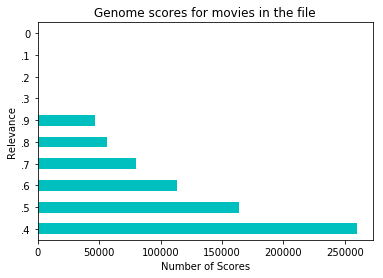

In [8]:
plt.ylabel('Relevance')
plt.xlabel('Number of Scores')
plt.title('Genome scores for movies in the file')
relevance_focuss['summary'].value_counts().plot(kind='barh', color='c');

#### Read cleansed Movies data file

In [10]:
csv_file = "Resources/cleansed_movies_data.csv"
movies_df = pd.read_csv(csv_file)
movies_df.head()

,movieId,Movie,Years,Genres
0,1,Toy Story,1995,"['Adventure', 'Animation', 'Children', 'Comedy..."
1,2,Jumanji,1995,"['Adventure', 'Children', 'Fantasy']"
2,3,Grumpier Old Men,1995,"['Comedy', 'Romance']"
3,4,Waiting to Exhale,1995,"['Comedy', 'Drama', 'Romance']"
4,5,Father of the Bride Part II,1995,['Comedy']


#### Read Genome Tags data file

In [13]:
csv_file = "Resources/genome-tags.csv"
genomed_tags_df = pd.read_csv(csv_file)
genomed_tags_df.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


#### Prepare the Movie Genome Relevance file

In [14]:
# Merge the Movies and Relevant Genome Scores
movies_genome_scores_df = pd.merge(movies_df, relevance_focuss, how='left', on='movieId')
movies_genome_scores_df.head()

,movieId,Movie,Years,Genres,tagId,relevance,summary
0,1,Toy Story,1995,"['Adventure', 'Animation', 'Children', 'Comedy...",11.0,0.57700,.5
1,1,Toy Story,1995,"['Adventure', 'Animation', 'Children', 'Comedy...",19.0,0.67050,.6
2,1,Toy Story,1995,"['Adventure', 'Animation', 'Children', 'Comedy...",29.0,0.89200,.8
3,1,Toy Story,1995,"['Adventure', 'Animation', 'Children', 'Comedy...",30.0,0.67625,.6
4,1,Toy Story,1995,"['Adventure', 'Animation', 'Children', 'Comedy...",33.0,0.40200,.4


In [15]:
# Merge the Movies Genome Scores and Genomoe Tags
movies_genome_scores_tags_df = pd.merge(movies_genome_scores_df, genomed_tags_df, how='left', on='tagId')
movies_genome_scores_tags_df.head()

,movieId,Movie,Years,Genres,tagId,relevance,summary,tag
0,1,Toy Story,1995,"['Adventure', 'Animation', 'Children', 'Comedy...",11.0,0.57700,.5,3d
1,1,Toy Story,1995,"['Adventure', 'Animation', 'Children', 'Comedy...",19.0,0.67050,.6,action
2,1,Toy Story,1995,"['Adventure', 'Animation', 'Children', 'Comedy...",29.0,0.89200,.8,adventure
3,1,Toy Story,1995,"['Adventure', 'Animation', 'Children', 'Comedy...",30.0,0.67625,.6,affectionate
4,1,Toy Story,1995,"['Adventure', 'Animation', 'Children', 'Comedy...",33.0,0.40200,.4,afi 100 (movie quotes)


In [16]:
len(movies_genome_scores_tags_df)

735524

### Prepare Data Collections (Records)

In [20]:
# Append data as STRINGS
movie_collections_string = []
for movie in range(len(movies_genome_scores_tags_df)):
    movie_collections_string.append(
        {
        'movieId'  : str(movies_genome_scores_tags_df['movieId'][movie]),
        'Name'     : movies_genome_scores_tags_df['Movie'][movie].strip(),
        'Year'     : str(movies_genome_scores_tags_df['Years'][movie]),
        'Generes'  : movies_genome_scores_tags_df['Genres'][movie].translate(str.maketrans({"[": "", "]": "", "'": ""})).split(","),
        'relevance': str(movies_genome_scores_tags_df['relevance'][movie]),
        'summary'  : str(movies_genome_scores_tags_df['summary'][movie]),
        'tag'      : movies_genome_scores_tags_df['tag'][movie],
    })

### Inserting Data Collections in Mongo DB

In [25]:
#Sample Collection (record)
movie_collections_string[0]

{'movieId': '1',
 'Name': 'Toy Story',
 'Year': '1995',
 'Generes': ['Adventure', ' Animation', ' Children', ' Comedy', ' Fantasy'],
 'relevance': '0.5770000000000001',
 'summary': '.5',
 'tag': '3d',
 '_id': ObjectId('5ce3067f229acc32aab24e48')}

In [21]:
# Declare the database
movies_db = client.movies_db

In [22]:
# Declare the collection
genome_relevance = movies_db.genome_relevance

In [23]:
genome_relevance.insert_many(movie_collections_string)